In [565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import xgboost as xgb

tscv = TimeSeriesSplit(n_splits=5)

from warnings import filterwarnings
filterwarnings('ignore')

In [476]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())


def plotModelResults(model, X_train, X_test, y_train, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    

def plotCoefficients(model, n_coeff = 21):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs[:n_coeff].coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [630]:
def prepareData(dataframe, target='FOODS', test_size=0.3, target_encoding = False, standard_scaling = False):
    data = dataframe.copy()
    targets = ['FOODS', 'HOBBIES', 'HOUSEHOLD']
    
    test_index = int( (1 - test_size) * data.shape[0] )
    
    # target encoding weekday and month
    if target_encoding:
        data['wday_average'] = list(map(code_mean(data[:test_index], 'wday', target).get, data.wday))
        data['month_average'] = list(map(code_mean(data[:test_index], 'month', target).get, data.month))
        data.drop(["wday", "month"], axis=1, inplace=True)
     
    # train-test split
    y = data.dropna()[target]
    X = data.dropna().drop(targets, axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    
    #standard scaling
    if standard_scaling:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    return X_train, X_test, y_train, y_test

In [4]:
calendar = pd.read_csv('calendar.csv')
sales = pd.read_csv('sales_train_validation.csv')
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [1489]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
targets = ['FOODS', 'HOBBIES', 'HOUSEHOLD']

In [1492]:
cat_mean = sales.groupby('cat_id').mean().T

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,1.612944,0.666195,0.543362
d_2,1.583716,0.594159,0.538109
d_3,1.195129,0.474690,0.375072
d_4,1.313709,0.472389,0.369150
d_5,1.016214,0.321062,0.260649
...,...,...,...
d_1909,1.644537,0.614513,0.786915
d_1910,1.622617,0.593451,0.798758
d_1911,1.858316,0.723009,0.929131
d_1912,2.221781,0.847257,1.169819


In [1601]:
date_feat = calendar.set_index('d').drop(['weekday', 'wm_yr_wk'], axis = 1).fillna(0)
date_feat['date'] = pd.to_datetime(date_feat.date)
zero_date = pd.datetime(2011,1,1)    
date_feat['days'] = pd.DataFrame((date_feat.date - zero_date).dt.days)

all_data = pd.concat([cat_mean, date_feat], axis = 1, join = 'inner')  
all_data = pd.get_dummies(all_data)

for target in targets:
    all_data[target] = all_data[target].apply(lambda x: round(x,2))

for col in all_data.filter(regex='^event_name_._[^0]').columns:    
    temp = pd.DataFrame()
    for i in all_data[all_data[f'{col}'] == 1].days:      
            temp = temp.append(all_data[(all_data.days - i) == -1])
            all_data[f'is_before_{col}'] = all_data.index.isin(temp.index).astype(int)

all_data.tail()

,FOODS,HOBBIES,HOUSEHOLD,date,wday,month,year,snap_CA,snap_TX,snap_WI,...,is_before_event_name_1_Ramadan starts,is_before_event_name_1_StPatricksDay,is_before_event_name_1_SuperBowl,is_before_event_name_1_Thanksgiving,is_before_event_name_1_ValentinesDay,is_before_event_name_1_VeteransDay,is_before_event_name_2_Cinco De Mayo,is_before_event_name_2_Easter,is_before_event_name_2_Father's day,is_before_event_name_2_OrthodoxEaster
d_1909,1.64,0.61,0.79,2016-04-20,5,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_1910,1.62,0.59,0.80,2016-04-21,6,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_1911,1.86,0.72,0.93,2016-04-22,7,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_1912,2.22,0.85,1.17,2016-04-23,1,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d_1913,2.27,0.83,1.19,2016-04-24,2,4,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1641]:
X_test = date_feat.copy()
X_test = pd.get_dummies(X_test) 

for col in test.filter(regex='^event_name_._[^0]').columns:    
    temp = pd.DataFrame()
    for i in X_test[X_test[f'{col}'] == 1].days:      
            temp = temp.append(X_test[(X_test.days - i) == -1])
            X_test[f'is_before_{col}'] = X_test.index.isin(temp.index).astype(int)
X_test = X_test.tail(56)
X_test.drop('date', axis = 1, inplace = True)

In [1643]:
def regressor(model, target, X_test, test_size = 0.2, trim_first = False, trim_fraction = 0.1,
              model_trend = False, plot_results = False, 
              plot_residuals = True, standard_scaling=False, plot_importances = True,
             hyp_opt = False, ):
    
    X_train, X_val, y_train, y_val = prepareData(all_data, target, test_size = test_size)
    
#     for col in X_test.columns:
#         if not col in test.columns:
#             print(f'{col}')
#     for i in range(len(test.columns)):
#         print(f'{test.columns[i]} : {X_test.columns[i]}')
            
    if trim_first:
        X_train = X_train.iloc[int(trim_fraction * X_train.shape[0]):]
        y_train = y_train.iloc[int(trim_fraction * y_train.shape[0]):]
        
    if model_trend:
        lr = LinearRegression()
        X_train_lr, X_val_lr, X_test_lr = pd.DataFrame(X_train.days), pd.DataFrame(X_val.days), pd.DataFrame(X_test.days)
        lr.fit(X_train_lr, y_train)

        lr_train = lr.predict(X_train_lr)
        lr_val = lr.predict(X_val_lr)
        lr_test = lr.predict(X_test_lr)
        
        X_train.drop(['date','days'], axis = 1, inplace = True)
        X_val.drop(['date','days'], axis = 1, inplace = True)
        X_test.drop(['days'], axis = 1, inplace = True)
        
        model.fit(X_train, y_train - lr_train)
        y_pred_train = model.predict(X_train) + lr_train
        y_pred_val = model.predict(X_val) + lr_val        
        y_pred_test = model.predict(X_test) + lr_test
    else: 
        X_train.drop(['date'], axis = 1, inplace = True)
        X_val.drop(['date'], axis = 1, inplace = True)
        #X_test.drop(['date'], axis = 1, inplace = True)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)        
        y_pred_test = model.predict(X_test)
        
    print(f'train MSE: {mean_absolute_error(y_train, y_pred_train)}')
    print(f'val MSE: {mean_absolute_error(y_test, y_pred_val)}')    
    print(f'std: {np.std(y_test)}')
    print(f'mean prediction: {abs(y_test-y_test.mean()).mean()}')
        
    if plot_results:
        plotModelResults(xgr, X_train, X_val, y_train, plot_intervals=True, plot_anomalies=True)
        plt.plot(y_pred_val + lr_val)
        plt.plot(y_val.values)
        
    if plot_residuals:
        res = y_pred_val - y_val
        plt.plot(y_pred - y_val.values)
        print('outliers:')
        outl = res[(res > 3*res.std())|(res < -3*res.std())]
        print(outl)
        
    if plot_importances:
        bst = xgr.get_booster()
        for kind in ['weight', 'gain',]: #'cover']:
            imp = pd.Series(bst.get_score(importance_type=kind))
            plt.figure()
            imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

    if hyp_opt:
        def score(params):
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['n_jobs'] = -1
            print("Training with params : ", params)
            xgbr = xgb.XGBRegressor(**params)
            xgbr.fit(X_train, y_train)
            y_xgbr_val = xgbr.predict(X_val)
            mse = mean_absolute_error(y_val, y_xgbr_val)
            result = {'loss': mse, 'status': STATUS_OK}
            print('TEST MSE: {0:.4f}'.format(mse))
            return result

        space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
                 'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
                 'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                 'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
                 'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
                 'silent' : 1,
                 'n_estimators': hp.quniform('n_estimators', 100,2000,100),
                 'learning_rate': hp.quniform('learning_rate', 0.001,0.1,0.001)
                 }
        trials = Trials()

        best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)
        
        print(f'best params from hyperopt: {best}')

      
    return y_pred_test

HOBBIES

train MSE: 0.06208665887294261
val MSE: 0.06364712063668083
std: 0.1030952569411565
mean prediction: 0.08163297861462004
outliers:
d_1617   -0.329460
d_1763    0.274441
d_1792    0.582922
Name: HOBBIES, dtype: float64


array([0.64100123, 0.64112068, 0.64124014, 0.64135959, 0.65649578,
       0.75115023, 0.7193547 , 0.64183741, 0.64195687, 0.64207632,
       0.64219577, 0.65733196, 0.75198641, 0.72019089, 0.64267359,
       0.64279305, 0.6429125 , 0.64303196, 0.65816814, 0.75282259,
       0.72102707, 0.64350977, 0.64362923, 0.64374868, 0.64386814,
       0.65900433, 0.75365877, 0.72186325, 0.64434596, 0.64446541,
       0.64458486, 0.64470432, 0.65984051, 0.75449496, 0.72269943,
       0.6145776 , 0.64530159, 0.64542105, 0.6455405 , 0.66067669,
       0.75533114, 0.72353561, 0.64601832, 0.64613777, 0.64625723,
       0.64637668, 0.66151287, 0.75616732, 0.72437179, 0.6468545 ,
       0.64697395, 0.64709341, 0.64721286, 0.66234905, 0.7570035 ,
       0.72520797])

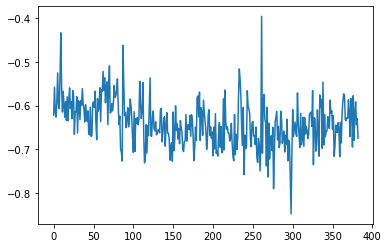

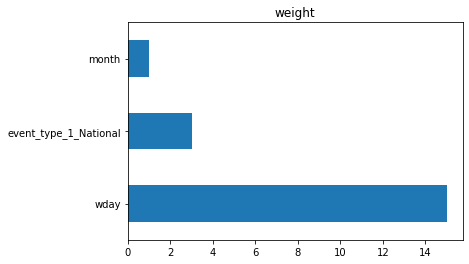

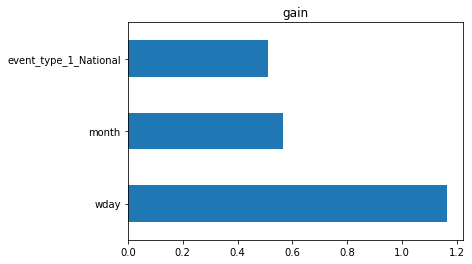

In [1644]:
# n_estimators = 150, max_depth = 5, colsample_bytree = 1, subsample = 1,
#                         n_jobs = -1, random_state = 21

params = {'colsample_bytree': 0.85, 'gamma': 0.55, 'learning_rate': 0.094, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 1400, 'subsample': 0.65}
xgr = xgb.XGBRegressor(**params)

regressor(xgr, target = 'HOBBIES', test = test.copy(), model_trend = True, hyp_opt=False, trim_first = True, 
                         trim_fraction=0.1)

FOODS

test MSE: 0.12392978379441814
train MSE: 0.102310161391186
std: 0.3187425764283065
mean prediction: 0.25229594584460974
outliers:
d_1599   -0.584999
d_1617   -0.606862
d_1765    0.504376
d_1792    0.551970
d_1883   -0.494650
d_1884   -0.520318
Name: FOODS, dtype: float64


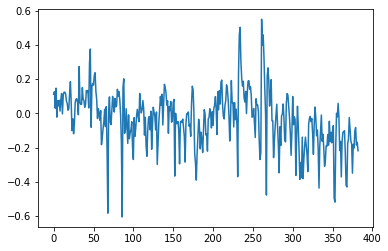

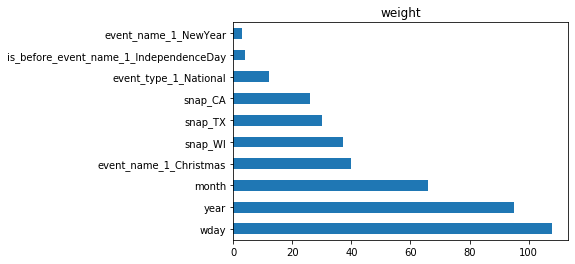

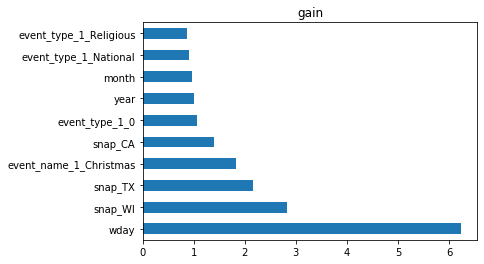

In [1557]:
# n_estimators = 30, max_depth = 5, 
#                        colsample_bytree = 0.4, subsample = 0.4,
#                         n_jobs = -1, random_state = 21
params = {'colsample_bytree': 0.6, 'gamma': 0.65, 'learning_rate': 0.04, 'max_depth': 4, 
          'min_child_weight': 3, 'n_estimators': 1100, 'subsample': 0.85}
xgr = xgb.XGBRegressor(**params)
    
test_foods = regressor(xgr, test_size = 0.2, target = 'FOODS', model_trend=True, trim_first = True, trim_fraction=0.1,
         hyp_opt=False, make_prediction=True)

HOUSEHOLD

test MSE: 0.07794166432824894
train MSE: 0.06885210179871327
std: 0.16984109630993233
mean prediction: 0.1389766103797832
outliers:
d_1617   -0.375044
d_1763    0.341047
d_1792    0.668631
Name: HOUSEHOLD, dtype: float64


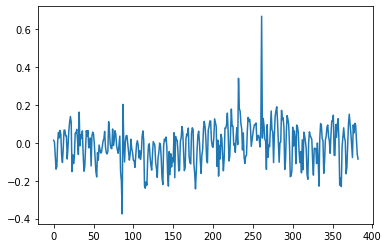

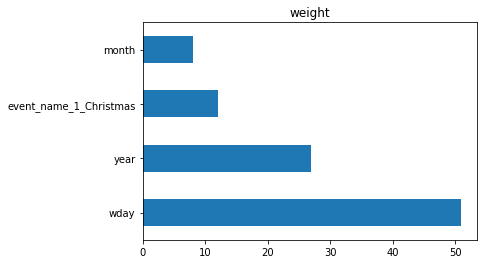

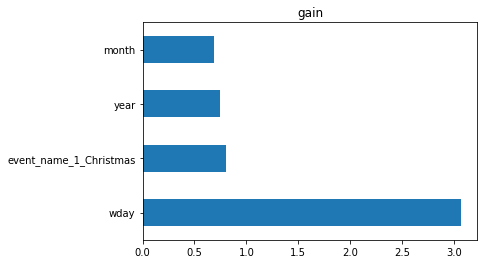

In [1559]:
# n_estimators = 350, max_depth = 5, 
#                        colsample_bytree = 0.1, 
#                        subsample = 0.1,                        n_jobs = -1, random_state = 21
params = {'colsample_bytree': 0.75, 'gamma': 0.7, 'learning_rate': 0.047, 'max_depth': 4,
          'min_child_weight': 2, 'n_estimators': 1500, 'subsample': 0.85}
xgr = xgb.XGBRegressor(**params)
    
test_household = regressor(xgr, test_size = 0.2, target = 'HOUSEHOLD', model_trend=True, 
                           hyp_opt=False, make_prediction=True)

In [1565]:
# sample_submission = sales.copy()
pd.DataFrame(test_foods[:28], index = test[:28].index).T

d,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,-0.220215,-0.321921,-0.321921,-0.321921,-0.184721,0.191243,0.295375,-0.031578,-0.055648,-0.215864,...,-0.094302,0.315012,0.363674,-0.209686,-0.30763,-0.30763,-0.30763,-0.17043,0.194492,0.194492


In [12]:
sales_ca1_hobbies_1 = sales.loc[(sales['dept_id'] == 'HOBBIES_1')&(sales['store_id'] == 'CA_1')]

sales_ca1_hobbies_1 = sales_ca1_hobbies_1.drop( sales_ca1_hobbies_1.filter(regex='_id$', axis = 1).columns, axis = 1 )

sales_ca1_hobbies_1 = sales_ca1_hobbies_1.set_index('id')

In [149]:
date = calendar.loc[:,['date', 'd']].set_index('d')

In [158]:
ts_1 = sales_ca1_hobbies_1.iloc[42]

ts_1 = pd.concat([date, ts_1], axis = 1, join = 'inner')

ts_1['date'] = pd.to_datetime(ts_1.date)

ts_1 = ts_1.set_index('date')

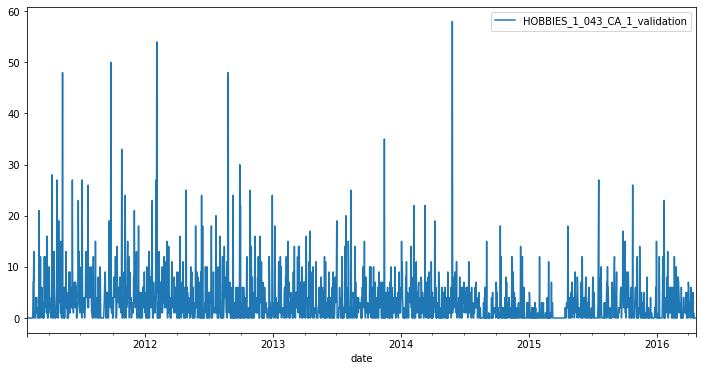

In [165]:
ts_1.plot(figsize=(12,6),)

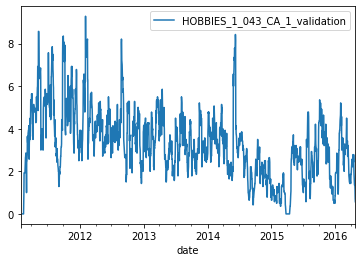

In [213]:
ts_2 = ts_1.rolling(14).mean()
ts_2.plot()

In [218]:
ts_2 = ts_2.dropna().rename(columns = {'HOBBIES_1_043_CA_1_validation': 'y'})

In [220]:
# Adding the lag of the target variable
for i in range(28, 400):
    ts_2["lag_{}".format(i)] = ts_2.y.shift(i)

In [221]:
ts_2.tail(10)

,y,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,...,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399
date,,,,,,,,,,,,,,,,,,,,,
2016-04-15,2.285714,1.785714,2.000000,2.571429,2.642857,3.214286,3.142857,3.142857,2.714286,3.428571,...,0.357143,0.428571,0.928571,0.928571,1.000000,1.000000,1.000000,1.000000,1.071429,1.071429
2016-04-16,1.928571,1.714286,1.785714,2.000000,2.571429,2.642857,3.214286,3.142857,3.142857,2.714286,...,0.214286,0.357143,0.428571,0.928571,0.928571,1.000000,1.000000,1.000000,1.000000,1.071429
2016-04-17,1.714286,1.571429,1.714286,1.785714,2.000000,2.571429,2.642857,3.214286,3.142857,3.142857,...,0.000000,0.214286,0.357143,0.428571,0.928571,0.928571,1.000000,1.000000,1.000000,1.000000
2016-04-18,1.500000,1.500000,1.571429,1.714286,1.785714,2.000000,2.571429,2.642857,3.214286,3.142857,...,0.000000,0.000000,0.214286,0.357143,0.428571,0.928571,0.928571,1.000000,1.000000,1.000000
2016-04-19,1.357143,1.500000,1.500000,1.571429,1.714286,1.785714,2.000000,2.571429,2.642857,3.214286,...,0.000000,0.000000,0.000000,0.214286,0.357143,0.428571,0.928571,0.928571,1.000000,1.000000
2016-04-20,1.357143,1.428571,1.500000,1.500000,1.571429,1.714286,1.785714,2.000000,2.571429,2.642857,...,0.000000,0.000000,0.000000,0.000000,0.214286,0.357143,0.428571,0.928571,0.928571,1.000000
2016-04-21,1.357143,1.500000,1.428571,1.500000,1.500000,1.571429,1.714286,1.785714,2.000000,2.571429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.357143,0.428571,0.928571,0.928571
2016-04-22,1.142857,1.857143,1.500000,1.428571,1.500000,1.500000,1.571429,1.714286,1.785714,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.357143,0.428571,0.928571
2016-04-23,0.714286,1.500000,1.857143,1.500000,1.428571,1.500000,1.500000,1.571429,1.714286,1.785714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214286,0.357143,0.428571


In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [243]:
y = ts_2.dropna().y
X = ts_2.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [244]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

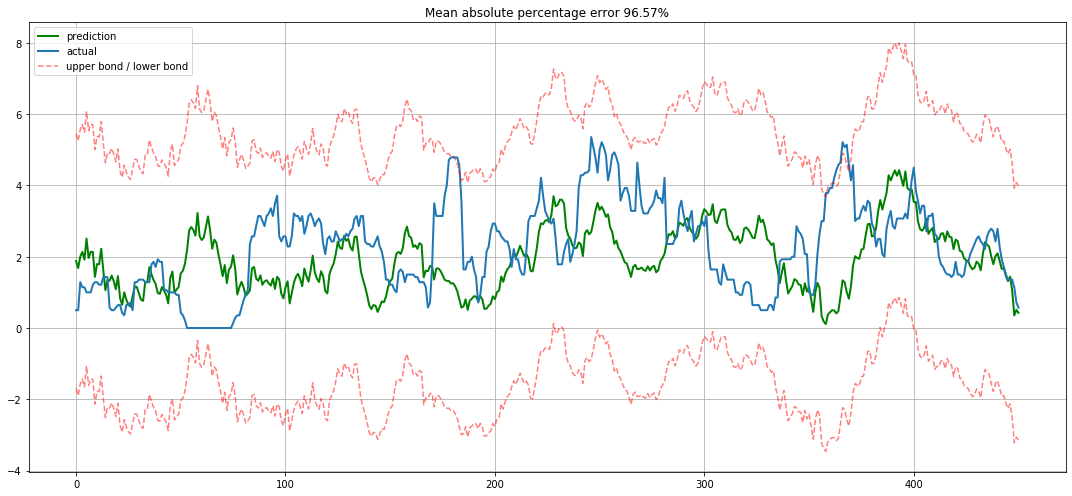

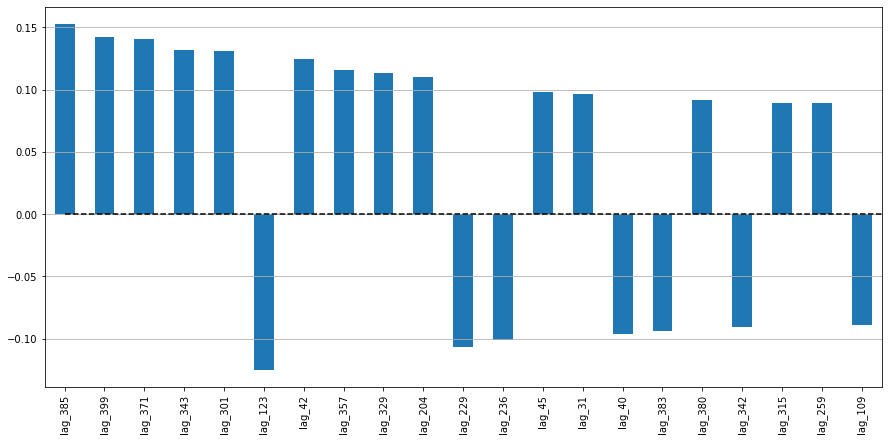

In [247]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Let's try raw series

In [248]:
ts_1 = ts_1.dropna().rename(columns = {'HOBBIES_1_043_CA_1_validation': 'y'})

In [268]:
# Adding the lag of the target variable
ts_1 = ts_1.filter(regex='y')
for i in [1,7,28,30,31,365]:
    ts_1["lag_{}".format(i)] = ts_1.y.shift(i)

C:\Users\pavlo\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [270]:
ts_1.tail(7)

,y,lag_1,lag_7,lag_28,lag_30,lag_31,lag_365
date,,,,,,,
2016-04-18,0,0.0,1.0,1.0,4.0,4.0,3.0
2016-04-19,0,0.0,0.0,1.0,1.0,4.0,3.0
2016-04-20,0,0.0,1.0,2.0,1.0,1.0,2.0
2016-04-21,0,0.0,5.0,1.0,1.0,1.0,2.0
2016-04-22,0,0.0,0.0,5.0,2.0,1.0,18.0
2016-04-23,0,0.0,1.0,1.0,1.0,2.0,3.0
2016-04-24,0,0.0,0.0,0.0,5.0,1.0,0.0


In [272]:
y = ts_1.dropna().y
X = ts_1.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [281]:
X_train

,lag_1,lag_7,lag_28,lag_30,lag_31,lag_365
date,,,,,,
2013-03-03,4.0,1.0,6.0,1.0,0.0,2.0
2013-03-04,14.0,3.0,0.0,4.0,1.0,15.0
2013-03-05,2.0,0.0,0.0,6.0,4.0,1.0
2013-03-06,2.0,1.0,8.0,0.0,6.0,0.0
2013-03-07,0.0,9.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...
2015-05-10,2.0,5.0,0.0,0.0,0.0,0.0
2015-05-11,4.0,0.0,0.0,0.0,0.0,0.0
2015-05-12,0.0,7.0,0.0,0.0,0.0,4.0


In [273]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [285]:
lr.score(X_test, y_test)

-0.009736555807562164

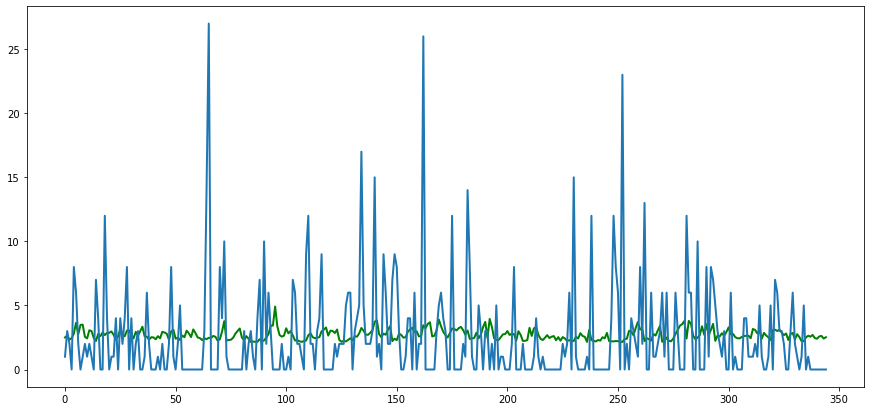

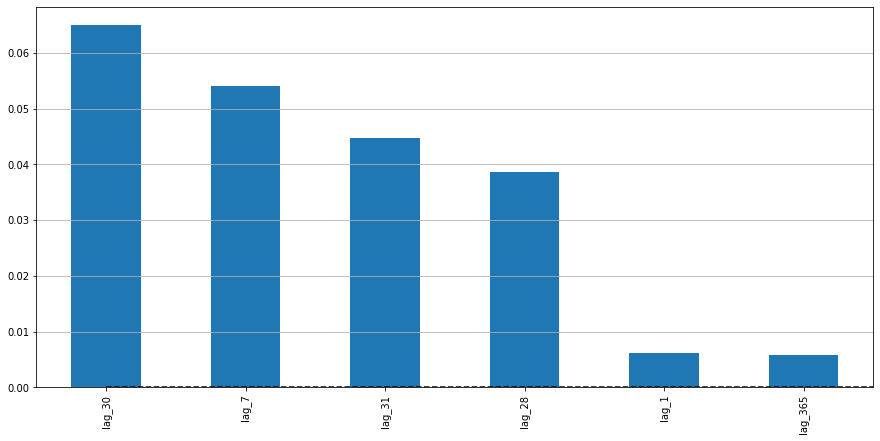

In [289]:
prediction = lr.predict(X_test)

plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_test.values, label="actual", linewidth=2.0)


coefs = pd.DataFrame(lr.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

plt.figure(figsize=(15, 7))
coefs[:21].coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');